In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate

from sklearn.metrics import precision_score, recall_score, accuracy_score, precision_recall_curve, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score

In [3]:
modern = pd.read_csv("modern_met_fe.csv")

In [4]:
modern.highlighted = modern.highlighted.apply(lambda x: 1 if x == True else 0)

In [5]:
modern.columns

Index(['highlighted', 'obj_year', 'department_drawings_and_prints',
       'department_european_paintings', 'department_modern_and_cont_art',
       'department_photographs', 'department_robert_lehman',
       'department_libraries', 'other_obj_name', 'obj_name_painting',
       'obj_name_photo', 'obj_name_print', 'obj_name_sculpture',
       'obj_name_watercolor', 'artist_role_author', 'artist_role_other',
       'artist_role_publisher', 'artist_nationality_bgdns',
       'artist_nationality_french', 'artist_nationality_italian',
       'artist_nationality_Other Nationality', 'medium_gelatin_silver_print',
       'medium_illustrated_book', 'medium_marble', 'medium_oil_on_canvas',
       'medium_oil_on_wood', 'medium_other', 'class_other', 'class_paintings',
       'class_photographs', 'class_prints', 'class_sculpture'],
      dtype='object')

**Target class ratios as well as the total sum of Positives**

In [6]:
modern.highlighted.mean()

0.0034778737670937494

In [7]:
modern.highlighted.sum()

750

Our lovely class imbalance in the target class is staring at us. We will deal with this both through threshold shifting after we build our models as well as during model training by looking at class balances. 

**Getting set up with train and validation sets**

In [8]:
X, y = modern.iloc[:, 1:], modern.iloc[:, 0]

In [9]:
scaler = StandardScaler()
X['obj_year'] = scaler.fit_transform(X.loc[:, 'obj_year'].values.reshape(-1, 1))

In [10]:
X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=.25, random_state=4)

We'll add our features consecutively in Part 1 to see how our scores improve and at the end, plot these scores to see what happened with the addition of each feature group. We will train our models with class weights 4:1, but then at the end will try out other class weights to see if there is an improvement. 

# Part 1: Feature Engineering

As we keep adding features, let's keep adding scores to a list so that we can compare them at the end. 

In [11]:
precision_scores = []
recall_scores = []
f1_scores = []
accuracy_scores = []
fp_num = []
tp_num = []
fn_num = []
tn_num = []
feature_group = []

**Helper Functions**

In [12]:
def build_visualize(X, y): 
    lr = LogisticRegression(class_weight={1 : 4, 0 : 1}, C=100, solver='liblinear', max_iter=500000)
    lr.fit(X, y)
    
    y_predict_prob = lr.predict_proba(X)
    y_predict_prob = y_predict_prob[:, 1]
    precision_curve, recall_curve, threshold_curve = precision_recall_curve(y, y_predict_prob)

    fig, axes = plt.subplots(nrows=2, ncols=2)
    fig.tight_layout()

    plt.subplot(1, 2, 1)
    fpr, tpr, thresholds = roc_curve(y, y_predict_prob)
    plt.plot(fpr, tpr,lw=2)
    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve for predicting higlighting')
    print("ROC AUC score = ", roc_auc_score(y, y_predict_prob)); 
    
    plt.subplot(1, 2, 2)
    plt.plot(threshold_curve, precision_curve[1:],label='precision')
    plt.plot(threshold_curve, recall_curve[1:], label='recall')
    plt.legend(loc='lower left')
    plt.xlabel('Threshold (above which highlight-possible)')
    plt.title('Precision and Recall Curves');

    return lr 

In [13]:
def threshold_for_imbalance(model, X, y): 
    thresh_pts = np.linspace(.10,.50,1000)
    model_pred_probs = model.predict_proba(X)[:,1] 

    f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
    for p in thresh_pts:
        model_pred_adjusted = model_pred_probs >= p
        f1_scores.append(f1_score(y, model_pred_adjusted))    
        prec_scores.append(precision_score(y, model_pred_adjusted))
        rec_scores.append(recall_score(y, model_pred_adjusted))
        acc_scores.append(accuracy_score(y, model_pred_adjusted))

#     #UNCOMMENT IF YOU ALSO WANT TO SEE PLOTS FOR THIS 
#     plt.plot(thresh_pts, f1_scores)
#     plt.plot(thresh_pts, prec_scores)
#     plt.plot(thresh_pts, rec_scores)
#     plt.plot(thresh_pts, acc_scores)

#     plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
#     plt.legend(['F1','Precision','Recall','Accuracy'], bbox_to_anchor=(1.05, 0), loc='lower left')
#     plt.xlabel('P threshold')
#     plt.ylabel('Metric score')

    # SETTING FOR THRESHOLD: 
    # This is setting the threshold to be at where the best precision score is achieved. 
    best_f1_score = np.max(f1_scores) 
    best_prec_score = np.max(prec_scores)
    best_thresh_p = thresh_pts[np.argmax(prec_scores)]

    print('Logistic Regression best Precision score %.3f at Prob Decision Threshold >= %.4f' 
          % (best_prec_score, best_thresh_p))

#     #THIS IS A TRY WITH F1 SCORES BEING THE METRIC
#     best_f1_score = np.max(f1_scores) 
#     best_prec_score = np.max(prec_scores)
#     best_thresh_p = thresh_pts[np.argmax(f1_scores)]
#     print('Logistic Regression best Precision score %.3f at Prob Decision Threshold >= %.4f' 
#           % (best_f1_score, best_thresh_p))

    return best_thresh_p

In [14]:
def model_score(model, threshold, X_test, y_test):
    model_accuracy = model.score(X_test, y_test)
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    y_predict_hard = (model.predict_proba(X_test)[:,1] >= threshold).astype(bool)
    model_precision = precision_score(y_test, y_predict_hard)
    model_recall = recall_score(y_test, y_predict_hard)
    model_f1 = f1_score(y_test, y_predict_hard)
    print(f"Accuracy score: {model_accuracy}")
    print("After adjusting for threshold -")
    print(f"Precision score: {model_precision}, Recall score: {model_recall}, F1 score: {model_f1}")
    precision_scores.append(model_precision)
    recall_scores.append(model_recall)
    f1_scores.append(model_f1)
    accuracy_scores.append(model_accuracy)

In [15]:
def model_confusion_matrix(model, threshold, X_test, y_test): 
    y_predict_hard = (model.predict_proba(X_test)[:,1] >= threshold).astype(bool)
    lr_confusion = confusion_matrix(y_test, y_predict_hard)
    print(lr_confusion)
    fp = lr_confusion[0][1]
    tp = lr_confusion[1][1]
    tn = lr_confusion[0][1]
    fn = lr_confusion[1][0]
    
    sns.heatmap(lr_confusion, annot=True, \
                xticklabels=['not','highlighted'], yticklabels=['not','highlighted'])
    plt.xlabel('Highlighting Predicted')
    plt.ylabel('Highlighting Actual')
    
    fp_num.append(fp)
    tp_num.append(tp)
    tn_num.append(tn)
    fn_num.append(fn)

## Try 1: Fit with only Department Features

In [16]:
# Choose the Department features
X_train_FE1_Dept = X_train[['department_drawings_and_prints',
       'department_european_paintings', 'department_modern_and_cont_art',
       'department_photographs', 'department_robert_lehman',
       'department_libraries']]
X_val_FE1_Dept = X_val[['department_drawings_and_prints',
       'department_european_paintings', 'department_modern_and_cont_art',
       'department_photographs', 'department_robert_lehman',
       'department_libraries']]
feature_group.append("Department added")

ROC AUC score =  0.8974419255961691


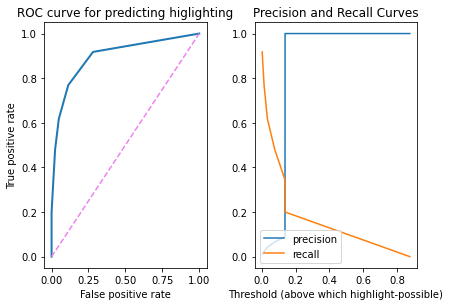

In [17]:
model = build_visualize(X_train_FE1_Dept, y_train)

In [18]:
threshold = threshold_for_imbalance(model, X_train_FE1_Dept, y_train)

Logistic Regression best Precision score 1.000 at Prob Decision Threshold >= 0.1376


In [19]:
model_score(model, threshold, X_val_FE1_Dept, y_val)

Accuracy score: 0.9973336424762347
After adjusting for threshold -
Precision score: 1.0, Recall score: 0.19014084507042253, F1 score: 0.31952662721893493


[[42988     0]
 [  115    27]]


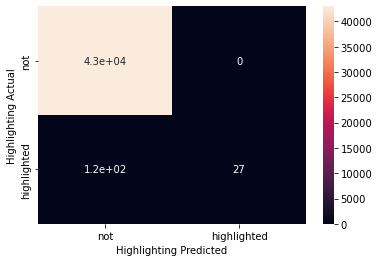

In [20]:
model_confusion_matrix(model, threshold, X_val_FE1_Dept, y_val)

## Try 2: Fit with Department & Object Name Features

In [21]:
# Choose the Department & Object Name features
X_train_FE2 = X_train[['department_drawings_and_prints',
       'department_european_paintings', 'department_modern_and_cont_art',
       'department_photographs', 'department_robert_lehman',
       'department_libraries', 'other_obj_name', 'obj_name_painting',
       'obj_name_photo', 'obj_name_print', 'obj_name_sculpture',
       'obj_name_watercolor']]
X_val_FE2 = X_val[['department_drawings_and_prints',
       'department_european_paintings', 'department_modern_and_cont_art',
       'department_photographs', 'department_robert_lehman',
       'department_libraries', 'other_obj_name', 'obj_name_painting',
       'obj_name_photo', 'obj_name_print', 'obj_name_sculpture',
       'obj_name_watercolor']]
feature_group.append("Object Name added")

ROC AUC score =  0.9220912731343245


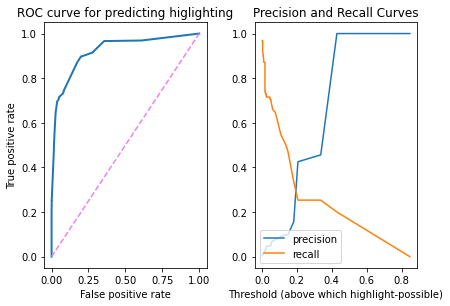

In [22]:
model = build_visualize(X_train_FE2, y_train)

In [23]:
threshold = threshold_for_imbalance(model, X_train_FE2, y_train)

Logistic Regression best Precision score 1.000 at Prob Decision Threshold >= 0.4295


In [24]:
model_score(model, threshold, X_val_FE2, y_val)

Accuracy score: 0.9973336424762347
After adjusting for threshold -
Precision score: 1.0, Recall score: 0.19014084507042253, F1 score: 0.31952662721893493


[[42988     0]
 [  115    27]]


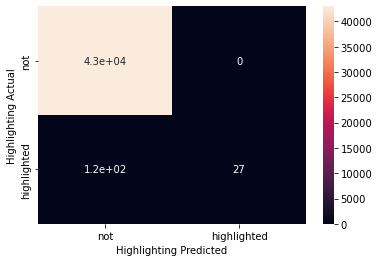

In [25]:
model_confusion_matrix(model, threshold, X_val_FE2, y_val)

## Try 3: Fit with Department & Object Name & Artist Role Features

In [26]:
# Choose the Department & Object Name & Artist Role features
X_train_FE3 = X_train[['department_drawings_and_prints',
       'department_european_paintings', 'department_modern_and_cont_art',
       'department_photographs', 'department_robert_lehman',
       'department_libraries', 'other_obj_name', 'obj_name_painting',
       'obj_name_photo', 'obj_name_print', 'obj_name_sculpture',
       'obj_name_watercolor', 'artist_role_author', 'artist_role_other',
       'artist_role_publisher']]
X_val_FE3 = X_val[['department_drawings_and_prints',
       'department_european_paintings', 'department_modern_and_cont_art',
       'department_photographs', 'department_robert_lehman',
       'department_libraries', 'other_obj_name', 'obj_name_painting',
       'obj_name_photo', 'obj_name_print', 'obj_name_sculpture',
       'obj_name_watercolor', 'artist_role_author', 'artist_role_other',
       'artist_role_publisher']]
feature_group.append("Artist Role added")

ROC AUC score =  0.9294123233122294


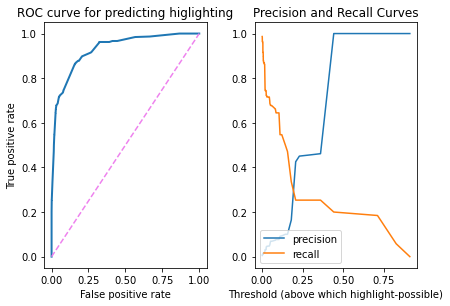

In [27]:
model = build_visualize(X_train_FE3, y_train)

In [28]:
threshold = threshold_for_imbalance(model, X_train_FE3, y_train)

Logistic Regression best Precision score 1.000 at Prob Decision Threshold >= 0.4427


In [29]:
model_score(model, threshold, X_val_FE3, y_val)

Accuracy score: 0.9973336424762347
After adjusting for threshold -
Precision score: 1.0, Recall score: 0.19014084507042253, F1 score: 0.31952662721893493


[[42988     0]
 [  115    27]]


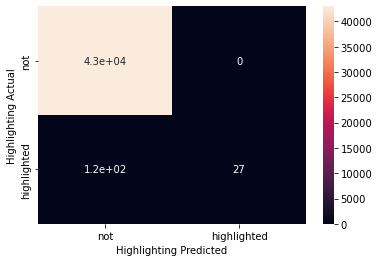

In [30]:
model_confusion_matrix(model, threshold, X_val_FE3, y_val)

## Try 4: Fit with Department & Object Name & Artist Role & Artist Nationality Features

In [31]:
# Choose the Department & Object Name & Artist Role features
X_train_FE4 = X_train[['department_drawings_and_prints',
       'department_european_paintings', 'department_modern_and_cont_art',
       'department_photographs', 'department_robert_lehman',
       'department_libraries', 'other_obj_name', 'obj_name_painting',
       'obj_name_photo', 'obj_name_print', 'obj_name_sculpture',
       'obj_name_watercolor', 'artist_role_author', 'artist_role_other',
       'artist_role_publisher', 'artist_nationality_bgdns',
       'artist_nationality_french', 'artist_nationality_italian',
       'artist_nationality_Other Nationality']]
X_val_FE4 = X_val[['department_drawings_and_prints',
       'department_european_paintings', 'department_modern_and_cont_art',
       'department_photographs', 'department_robert_lehman',
       'department_libraries', 'other_obj_name', 'obj_name_painting',
       'obj_name_photo', 'obj_name_print', 'obj_name_sculpture',
       'obj_name_watercolor', 'artist_role_author', 'artist_role_other',
       'artist_role_publisher', 'artist_nationality_bgdns',
       'artist_nationality_french', 'artist_nationality_italian',
       'artist_nationality_Other Nationality']]
feature_group.append("Artist Nationality added")

ROC AUC score =  0.9340141979282193


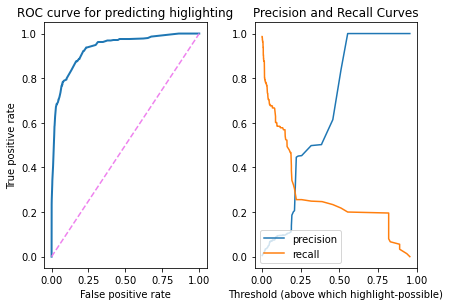

In [32]:
model = build_visualize(X_train_FE4, y_train)

In [33]:
threshold = threshold_for_imbalance(model, X_train_FE4, y_train)

Logistic Regression best Precision score 0.614 at Prob Decision Threshold >= 0.4576


In [34]:
model_score(model, threshold, X_val_FE4, y_val)

Accuracy score: 0.9970090424298632
After adjusting for threshold -
Precision score: 0.6226415094339622, Recall score: 0.2323943661971831, F1 score: 0.3384615384615385


[[42968    20]
 [  109    33]]


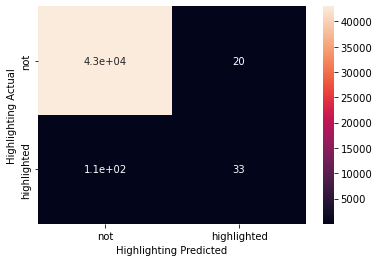

In [35]:
model_confusion_matrix(model, threshold, X_val_FE4, y_val)

## Try 5: Fit adding Medium Features

In [36]:
# Choose the Department & Object Name & Artist Role features
X_train_FE5 = X_train[['department_drawings_and_prints',
       'department_european_paintings', 'department_modern_and_cont_art',
       'department_photographs', 'department_robert_lehman',
       'department_libraries', 'other_obj_name', 'obj_name_painting',
       'obj_name_photo', 'obj_name_print', 'obj_name_sculpture',
       'obj_name_watercolor', 'artist_role_author', 'artist_role_other',
       'artist_role_publisher', 'artist_nationality_bgdns',
       'artist_nationality_french', 'artist_nationality_italian',
       'artist_nationality_Other Nationality', 'medium_gelatin_silver_print',
       'medium_illustrated_book', 'medium_marble', 'medium_oil_on_canvas',
       'medium_oil_on_wood', 'medium_other']]
X_val_FE5 = X_val[['department_drawings_and_prints',
       'department_european_paintings', 'department_modern_and_cont_art',
       'department_photographs', 'department_robert_lehman',
       'department_libraries', 'other_obj_name', 'obj_name_painting',
       'obj_name_photo', 'obj_name_print', 'obj_name_sculpture',
       'obj_name_watercolor', 'artist_role_author', 'artist_role_other',
       'artist_role_publisher', 'artist_nationality_bgdns',
       'artist_nationality_french', 'artist_nationality_italian',
       'artist_nationality_Other Nationality', 'medium_gelatin_silver_print',
       'medium_illustrated_book', 'medium_marble', 'medium_oil_on_canvas',
       'medium_oil_on_wood', 'medium_other']]
feature_group.append("Medium added")

ROC AUC score =  0.9353974101448489


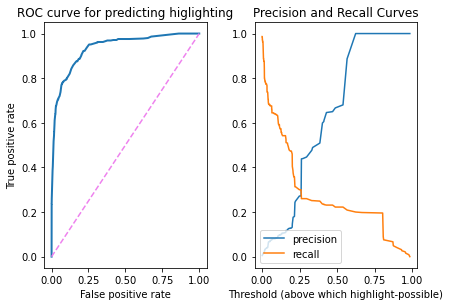

In [37]:
model = build_visualize(X_train_FE5, y_train)

In [38]:
threshold = threshold_for_imbalance(model, X_train_FE5, y_train)

Logistic Regression best Precision score 0.667 at Prob Decision Threshold >= 0.4872


In [39]:
model_score(model, threshold, X_val_FE5, y_val)

Accuracy score: 0.997171342453049
After adjusting for threshold -
Precision score: 0.717391304347826, Recall score: 0.2323943661971831, F1 score: 0.35106382978723405


[[42975    13]
 [  109    33]]


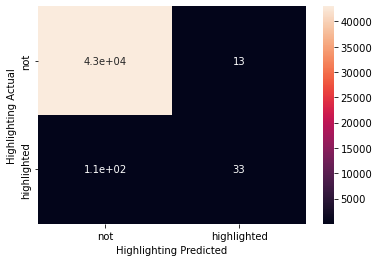

In [40]:
model_confusion_matrix(model, threshold, X_val_FE5, y_val)

## Try 6: Fit adding Class Features

In [41]:
# Choose the Department & Object Name & Artist Role features
X_train_FE6 = X_train[['department_drawings_and_prints',
       'department_european_paintings', 'department_modern_and_cont_art',
       'department_photographs', 'department_robert_lehman',
       'department_libraries', 'other_obj_name', 'obj_name_painting',
       'obj_name_photo', 'obj_name_print', 'obj_name_sculpture',
       'obj_name_watercolor', 'artist_role_author', 'artist_role_other',
       'artist_role_publisher', 'artist_nationality_bgdns',
       'artist_nationality_french', 'artist_nationality_italian',
       'artist_nationality_Other Nationality', 'medium_gelatin_silver_print',
       'medium_illustrated_book', 'medium_marble', 'medium_oil_on_canvas',
       'medium_oil_on_wood', 'medium_other', 'class_other', 'class_paintings',
       'class_photographs', 'class_prints', 'class_sculpture']]
X_val_FE6 = X_val[['department_drawings_and_prints',
       'department_european_paintings', 'department_modern_and_cont_art',
       'department_photographs', 'department_robert_lehman',
       'department_libraries', 'other_obj_name', 'obj_name_painting',
       'obj_name_photo', 'obj_name_print', 'obj_name_sculpture',
       'obj_name_watercolor', 'artist_role_author', 'artist_role_other',
       'artist_role_publisher', 'artist_nationality_bgdns',
       'artist_nationality_french', 'artist_nationality_italian',
       'artist_nationality_Other Nationality', 'medium_gelatin_silver_print',
       'medium_illustrated_book', 'medium_marble', 'medium_oil_on_canvas',
       'medium_oil_on_wood', 'medium_other', 'class_other', 'class_paintings',
       'class_photographs', 'class_prints', 'class_sculpture']]
feature_group.append("Classification added")

ROC AUC score =  0.9354742595766646


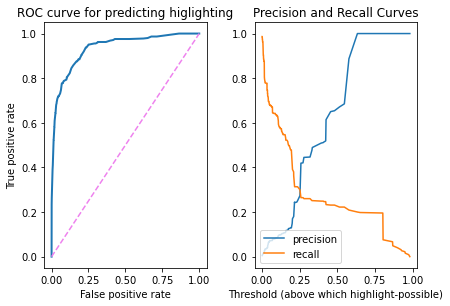

In [42]:
model = build_visualize(X_train_FE6, y_train)

In [43]:
threshold = threshold_for_imbalance(model, X_train_FE6, y_train)

Logistic Regression best Precision score 0.654 at Prob Decision Threshold >= 0.4812


In [44]:
model_score(model, threshold, X_val_FE6, y_val)

Accuracy score: 0.9971017853002551
After adjusting for threshold -
Precision score: 0.673469387755102, Recall score: 0.2323943661971831, F1 score: 0.34554973821989526


[[42972    16]
 [  109    33]]


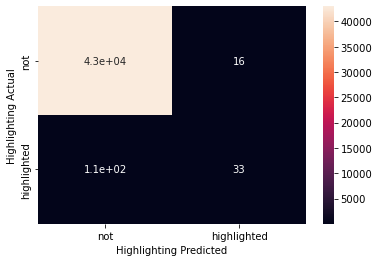

In [45]:
model_confusion_matrix(model, threshold, X_val_FE6, y_val)

## Try 7: Fit adding Object Year Feature

In [46]:
# Choose the Department & Object Name & Artist Role features
X_train_FE7 = X_train[['obj_year', 'department_drawings_and_prints',
       'department_european_paintings', 'department_modern_and_cont_art',
       'department_photographs', 'department_robert_lehman',
       'department_libraries', 'other_obj_name', 'obj_name_painting',
       'obj_name_photo', 'obj_name_print', 'obj_name_sculpture',
       'obj_name_watercolor', 'artist_role_author', 'artist_role_other',
       'artist_role_publisher', 'artist_nationality_bgdns',
       'artist_nationality_french', 'artist_nationality_italian',
       'artist_nationality_Other Nationality', 'medium_gelatin_silver_print',
       'medium_illustrated_book', 'medium_marble', 'medium_oil_on_canvas',
       'medium_oil_on_wood', 'medium_other', 'class_other', 'class_paintings',
       'class_photographs', 'class_prints', 'class_sculpture']]
X_val_FE7 = X_val[['obj_year', 'department_drawings_and_prints',
       'department_european_paintings', 'department_modern_and_cont_art',
       'department_photographs', 'department_robert_lehman',
       'department_libraries', 'other_obj_name', 'obj_name_painting',
       'obj_name_photo', 'obj_name_print', 'obj_name_sculpture',
       'obj_name_watercolor', 'artist_role_author', 'artist_role_other',
       'artist_role_publisher', 'artist_nationality_bgdns',
       'artist_nationality_french', 'artist_nationality_italian',
       'artist_nationality_Other Nationality', 'medium_gelatin_silver_print',
       'medium_illustrated_book', 'medium_marble', 'medium_oil_on_canvas',
       'medium_oil_on_wood', 'medium_other', 'class_other', 'class_paintings',
       'class_photographs', 'class_prints', 'class_sculpture']]
feature_group.append("Object Year added")

ROC AUC score =  0.9395617738275894


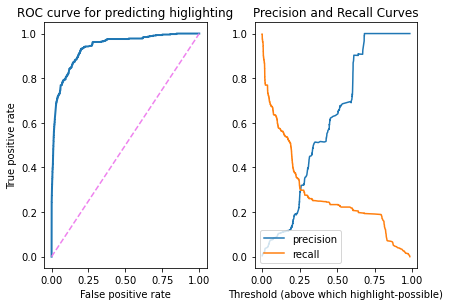

In [47]:
model = build_visualize(X_train_FE7, y_train)

In [48]:
threshold = threshold_for_imbalance(model, X_train_FE7, y_train)

Logistic Regression best Precision score 0.636 at Prob Decision Threshold >= 0.4956


In [49]:
model_score(model, threshold, X_val_FE7, y_val)

Accuracy score: 0.9970322281474612
After adjusting for threshold -
Precision score: 0.6346153846153846, Recall score: 0.2323943661971831, F1 score: 0.34020618556701027


[[42969    19]
 [  109    33]]


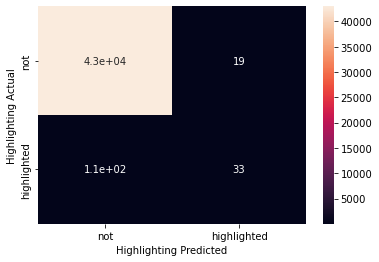

In [50]:
model_confusion_matrix(model, threshold, X_val_FE7, y_val)

## Try 8: Get Some Polynomial Features

In [51]:
X_train_FE8 = X_train_FE7.copy()
X_val_FE8 = X_val_FE7.copy()
feature_group.append("Polynomial added ")

In [52]:
obj_year_array = X_train_FE8.obj_year.values.reshape(-1, 1)
obj_year_array.shape

(129389, 1)

In [53]:
poly = PolynomialFeatures(3)
new_features = poly.fit_transform(obj_year_array)
new_features.shape 

(129389, 4)

In [54]:
new_feature_names = poly.get_feature_names()
print(new_feature_names)

['1', 'x0', 'x0^2', 'x0^3']


In [55]:
new_features_df = pd.DataFrame(new_features, columns = new_feature_names)
new_features_df

,1,x0,x0^2,x0^3
0,1.0,-2.726368,7.433083,-20.265321
1,1.0,0.511317,0.261445,0.133681
2,1.0,0.494567,0.244596,0.120969
3,1.0,0.502942,0.252950,0.127219
4,1.0,0.437619,0.191510,0.083808
...,...,...,...,...
129384,1.0,0.514666,0.264882,0.136326
129385,1.0,0.544816,0.296824,0.161714
129386,1.0,-0.063192,0.003993,-0.000252
129387,1.0,0.494567,0.244596,0.120969


In [56]:
print(new_features_df.shape)
print(X_train_FE8.shape)

(129389, 4)
(129389, 31)


In [57]:
new_features_df.reset_index(drop=True, inplace=True)
X_train_FE8.reset_index(drop=True, inplace=True)

X_train_FE8 = pd.concat([X_train_FE8, new_features_df], axis=1)
print(X_train_FE8.shape)
X_train_FE8

(129389, 35)


,obj_year,department_drawings_and_prints,department_european_paintings,department_modern_and_cont_art,department_photographs,department_robert_lehman,department_libraries,other_obj_name,obj_name_painting,obj_name_photo,...,medium_other,class_other,class_paintings,class_photographs,class_prints,class_sculpture,1,x0,x0^2,x0^3
0,-2.726368,0,0,0,1,0,0,0,0,1,...,1,0,0,1,0,0,1.0,-2.726368,7.433083,-20.265321
1,0.511317,1,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,1.0,0.511317,0.261445,0.133681
2,0.494567,0,0,1,0,0,0,0,1,0,...,0,0,1,0,0,0,1.0,0.494567,0.244596,0.120969
3,0.502942,0,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,1.0,0.502942,0.252950,0.127219
4,0.437619,1,0,0,0,0,0,0,0,1,...,1,1,0,0,0,0,1.0,0.437619,0.191510,0.083808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129384,0.514666,1,0,0,0,0,0,1,0,0,...,1,1,0,0,0,0,1.0,0.514666,0.264882,0.136326
129385,0.544816,1,0,0,0,0,0,1,0,0,...,1,1,0,0,0,0,1.0,0.544816,0.296824,0.161714
129386,-0.063192,1,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,1.0,-0.063192,0.003993,-0.000252
129387,0.494567,0,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,1.0,0.494567,0.244596,0.120969


Let's do the same operation for the Validation set 

In [58]:
obj_year_array_val = X_val_FE8.obj_year.values.reshape(-1, 1)

poly_val = PolynomialFeatures(3)
new_features_val = poly_val.fit_transform(obj_year_array_val)
new_feature_names_val = poly_val.get_feature_names()

new_features_df_val = pd.DataFrame(new_features_val, columns = new_feature_names_val)
new_features_df_val.reset_index(drop=True, inplace=True)
X_val_FE8.reset_index(drop=True, inplace=True)

X_val_FE8 = pd.concat([X_val_FE8, new_features_df_val], axis=1)
X_val_FE8

,obj_year,department_drawings_and_prints,department_european_paintings,department_modern_and_cont_art,department_photographs,department_robert_lehman,department_libraries,other_obj_name,obj_name_painting,obj_name_photo,...,medium_other,class_other,class_paintings,class_photographs,class_prints,class_sculpture,1,x0,x0^2,x0^3
0,-2.726368,0,0,0,1,0,0,1,0,0,...,1,0,0,1,0,0,1.0,-2.726368,7.433083,-20.265321
1,-0.066542,1,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,1.0,-0.066542,0.004428,-0.000295
2,-2.726368,0,0,1,0,0,0,1,0,0,...,1,1,0,0,0,0,1.0,-2.726368,7.433083,-20.265321
3,0.526391,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,1.0,0.526391,0.277088,0.145856
4,-0.289311,0,0,0,0,1,0,0,1,0,...,1,0,1,0,0,0,1.0,-0.289311,0.083701,-0.024216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43125,-2.726368,0,0,0,1,0,0,0,0,1,...,1,0,0,1,0,0,1.0,-2.726368,7.433083,-20.265321
43126,0.472793,1,0,0,0,0,0,1,0,0,...,1,1,0,0,0,0,1.0,0.472793,0.223533,0.105685
43127,0.514666,0,0,1,0,0,0,1,0,0,...,1,1,0,0,0,0,1.0,0.514666,0.264882,0.136326
43128,0.288548,1,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,1.0,0.288548,0.083260,0.024024


Alright, now onto fitting the model & plotting/scoring

ROC AUC score =  0.941723054226331


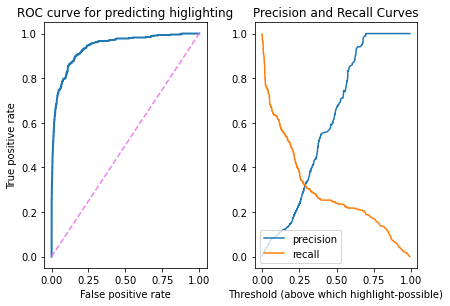

In [59]:
model = build_visualize(X_train_FE8, y_train)

In [60]:
threshold = threshold_for_imbalance(model, X_train_FE8, y_train)

Logistic Regression best Precision score 0.667 at Prob Decision Threshold >= 0.4992


In [61]:
model_score(model, threshold, X_val_FE8, y_val)

Accuracy score: 0.9970785995826571
After adjusting for threshold -
Precision score: 0.6379310344827587, Recall score: 0.2605633802816901, F1 score: 0.37


[[42967    21]
 [  105    37]]


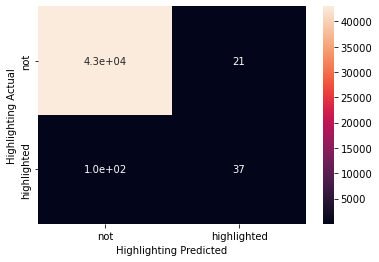

In [62]:
model_confusion_matrix(model, threshold, X_val_FE8, y_val)

## See scores over Feature Addition

In [63]:
for i in range(8): 
    print(f'After addition of Feature Group {i}: Precision score is {precision_scores[i]}.')
print('\n')
for i in range(8): 
    print(f'After addition of Feature Group {feature_group[i]}: Accuracy score is {accuracy_scores[i]}.')
print('\n')
for i in range(8): 
    print(f'After addition of Feature Group {i}: F1 score is {f1_scores[i]}.')
print('\n')    
for i in range(8): 
    print(f'After addition of Feature Group {i}: Recall score is {recall_scores[i]}.')
print('\n')
for i in range(8): 
    print(f'After addition of Feature Group {i}: FP Numbers are {fp_num[i]}.')
print('\n')    
for i in range(8): 
    print(f'After addition of Feature Group {i}: TP Numbers are {tp_num[i]}.')


After addition of Feature Group 0: Precision score is 1.0.
After addition of Feature Group 1: Precision score is 1.0.
After addition of Feature Group 2: Precision score is 1.0.
After addition of Feature Group 3: Precision score is 0.6226415094339622.
After addition of Feature Group 4: Precision score is 0.717391304347826.
After addition of Feature Group 5: Precision score is 0.673469387755102.
After addition of Feature Group 6: Precision score is 0.6346153846153846.
After addition of Feature Group 7: Precision score is 0.6379310344827587.


After addition of Feature Group Department added: Accuracy score is 0.9973336424762347.
After addition of Feature Group Object Name added: Accuracy score is 0.9973336424762347.
After addition of Feature Group Artist Role added: Accuracy score is 0.9973336424762347.
After addition of Feature Group Artist Nationality added: Accuracy score is 0.9970090424298632.
After addition of Feature Group Medium added: Accuracy score is 0.997171342453049.
After ad

**Plot Scores after each group addition**

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


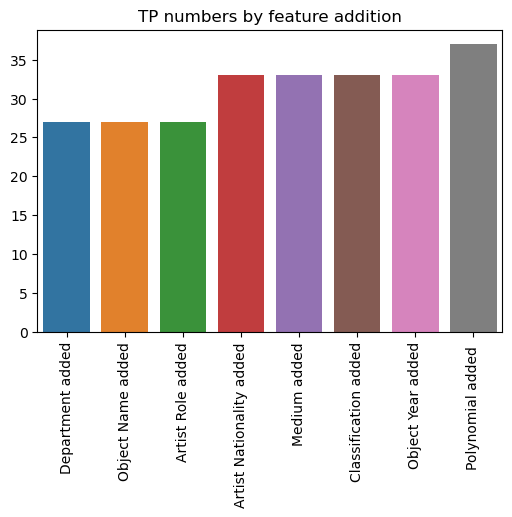

In [64]:
plt.figure(dpi=100)
g = sns.barplot(feature_group, tp_num)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('TP numbers by feature addition')
g.figure.savefig("TP numbers by feature addition", bbox_inches='tight')

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


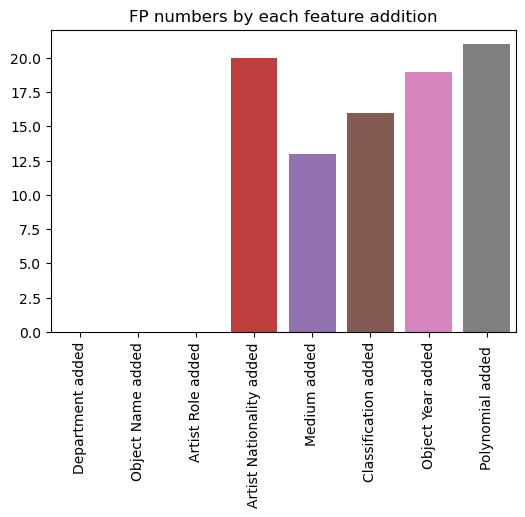

In [65]:
plt.figure(dpi=100)
g = sns.barplot(feature_group, fp_num)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('FP numbers by each feature addition')
g.figure.savefig("FP numbers by each feature addition", bbox_inches='tight')

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


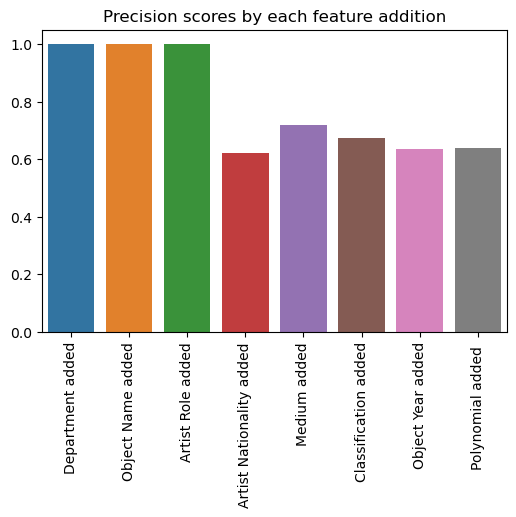

In [66]:
plt.figure(dpi=100)
g = sns.barplot(feature_group, precision_scores)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Precision scores by each feature addition')
g.figure.savefig("Precision scores by each feature addition", bbox_inches='tight')


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


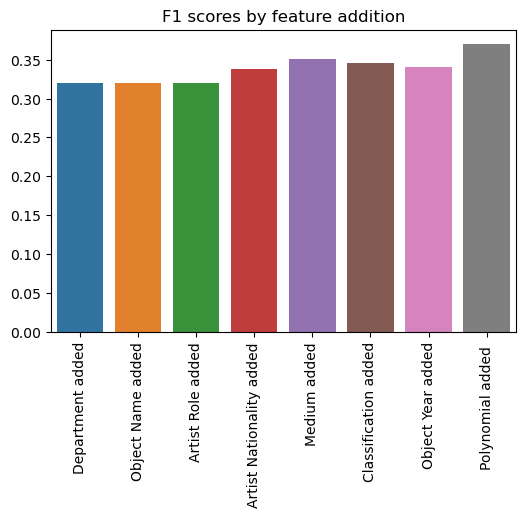

In [67]:
plt.figure(dpi=100)
g = sns.barplot(feature_group, f1_scores)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('F1 scores by feature addition')
g.figure.savefig("F1 scores by feature addition", bbox_inches='tight')


In [68]:
data = threshold
%store data
del data

Stored 'data' (float64)


# Part 2: Class Imbalance Fixing

**Now let's see about best class weight for during model training** 

In [93]:
threshold

0.4991991991991992

In [145]:
lr_balanced = LogisticRegression(class_weight='balanced', solver='liblinear', C=100, max_iter=500000)
lr_balanced.fit(X_train_FE8, y_train)

LogisticRegression(C=100, class_weight='balanced', max_iter=500000,
                   solver='liblinear')

In [146]:
y_predict_weight = (lr_balanced.predict_proba(X_val_FE8)[:,1]).astype(bool)
print(y_predict_weight)
prec_balanced = precision_score(y_val, y_predict_weight)
f1_balanaced = f1_score(y_val, y_predict_weight)
print(prec_balanced)
print(f1_balanaced)

[ True  True  True ...  True  True  True]
0.0032923718989102714
0.006563135514882604


In [147]:
weight_prec_scores = []
weight_f1_scores = []
for i in np.linspace(.10,10,50):
    lr_weight = LogisticRegression(class_weight={1 : i, 0 : 1}, solver='liblinear', C=100, max_iter=500000)
    lr_weight.fit(X_train_FE8, y_train)
    y_predict_weight = (lr_weight.predict_proba(X_val_FE8)[:,1]).astype(bool)
    weight_prec_scores.append(precision_score(y_val, y_predict_weight))
    weight_f1_scores.append(f1_score(y_val, y_predict_weight))

In [148]:
print(weight_prec_scores)
print(weight_f1_scores)

[0.0032923718989102714, 0.0032923718989102714, 0.0032923718989102714, 0.0032923718989102714, 0.0032923718989102714, 0.0032923718989102714, 0.0032923718989102714, 0.0032923718989102714, 0.0032923718989102714, 0.0032923718989102714, 0.0032923718989102714, 0.0032923718989102714, 0.0032923718989102714, 0.0032923718989102714, 0.0032923718989102714, 0.0032923718989102714, 0.0032923718989102714, 0.0032923718989102714, 0.0032923718989102714, 0.0032923718989102714, 0.0032923718989102714, 0.0032923718989102714, 0.0032923718989102714, 0.0032923718989102714, 0.0032923718989102714, 0.0032923718989102714, 0.0032923718989102714, 0.0032923718989102714, 0.0032923718989102714, 0.0032923718989102714, 0.0032923718989102714, 0.0032923718989102714, 0.0032923718989102714, 0.0032923718989102714, 0.0032923718989102714, 0.0032923718989102714, 0.0032923718989102714, 0.0032923718989102714, 0.0032923718989102714, 0.0032923718989102714, 0.0032923718989102714, 0.0032923718989102714, 0.0032923718989102714, 0.00329237

Doesn't seem to make too much of a difference, so we'll stick with our 1:4 class weights as we have. 